In [1]:
#example of how to use the tropo package

In [19]:
import tropo
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#  input:    temp(nlon,nlat,nlev)    3D-temperature field
# !           nlon                    # of grid points in x
# !           nlat                    # of grid points in y
# !           nlev                    # of vertical pressure levels
# !           pres(nlev)              array of pressure levels in hPa, length = nlev
# !           plimu                   upper limit for tropopause pressure in Pa, usually 45000
# !           pliml                   lower limit for tropopause pressure in Pa, usually 7500
# !           plimlex                 lower limit in extratropics, usually same as pliml, i.e., 7500
# !           dofill                  fill undefined values with neighboring points if .true.
# !
# ! output:   tp(nlon, nlat)          tropopause pressure in Pa, same horizontal dimension as temp
# !           tperr                   # of undetermined values
# !

In [64]:
def calc_tropopause(temperature):
    #Input the temperature (time, lon,lat,lev)
    #The vertical level should be pressure
    plimu=45000
    pliml=7500
    plimlex=7500
    dofill=True
    #transpose the dimension of temperature to match the fortran code
    temperature = temperature.transpose('time', 'lon', 'lat', 'plev')
    ntime, nlon,nlat,nlev = temperature.shape
    pres = temperature['plev']/100 #pressure in hPa

    #xarray for result
    dims = ('time', 'lon', 'lat')
    coords = {dim: temperature.coords[dim] for dim in dims}
    # Create an empty DataArray with the specified dimensions and coordinates
    tp = xr.DataArray(np.nan, dims=dims, coords=coords,name='tp')

    for time in range(ntime):
        t = temperature.isel(time=time)
        temptp,tperr= tropo.tropo(t,pres,plimu,pliml,plimlex,dofill)
        tp[dict(time=time)] = temptp    
    return tp

In [54]:
# load a example temperature data

t = xr.open_dataset(r'/uio/kant/geo-geofag-u1/cheh/Research/Data/temp/ta_Amon_NorESM2-LM_abrupt-4xCO2_r1i1p1f1_gn_000101-001012.nc')

In [55]:
t['ta']

<xarray.DataArray 'ta' (time: 120, plev: 19, lat: 96, lon: 144)>
[31518720 values with dtype=float32]
Coordinates:
  * time     (time) object 0001-01-16 12:00:00 ... 0010-12-16 12:00:00
  * plev     (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    standard_name:  air_temperature
    long_name:      Air Temperature
    comment:        Air Temperature
    units:          K
    original_name:  T
    cell_methods:   time: mean
    cell_measures:  area: areacella
    history:        2019-12-12T07:22:18Z altered by CMOR: Converted type from...

In [56]:
tp = calc_tropopause(t['ta'])

In [61]:
tp = tp/100

In [62]:
tpmean = tp.mean(dim='time')

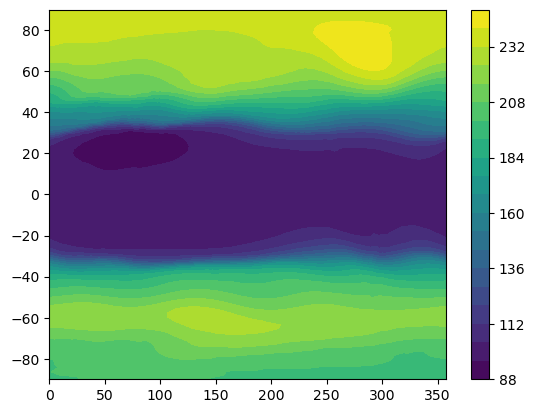

In [63]:
plt.contourf(tpmean['lon'],tpmean['lat'],tpmean.T,levels=20)
plt.colorbar()